# 3.7 "찐" Multi-Agent System (feat. create_react_agent)

- 도구들을 활용하는 에이전트들이 협업하는 과정을 구현합니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = "gpt-4o"  
)

small_llm = ChatOpenAI(
    model = "gpt-4o-mini"
)

In [3]:
# %pip install --upgrade --quiet  yfinance

In [4]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

# Polygon API를 초기화합니다.
polygon = PolygonAPIWrapper()

# Polygon API로부터 도구 모음을 생성합니다.
toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)

# 도구들을 가져옵니다.
polygon_tools = toolkit.get_tools()

# 시장 조사 도구 목록을 생성합니다.
market_research_tools = [YahooFinanceNewsTool()] + polygon_tools

# 시장 조사 에이전트를 생성합니다. 시장 조사만 하고 의견은 내지 않는다.
market_research_agent = create_react_agent(
    llm, 
    tools=market_research_tools, 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)
# state_modifier: 프롬프트로 페르소나를 부여한 것과 유사사

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node입니다. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )
    # market_research_agent는 react를 사용하므로 메시지가 길다. 
    # 그래서 마지막 메시지만 가져온다. 그리고 name에 'market_research'라는것도 남겨준다.
    

USER_AGENT environment variable not set, consider setting it to identify your requests.


스톡 정보를 가져오는 에이전트 노드

In [5]:
import yfinance as yf

from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info


stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node입니다. 주어진 State를 기반으로 주식 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )

재무재표 정보 가져오는 에이전트

In [6]:
@tool
def company_research_tool(ticker: str) -> dict: # 인자가 state가 아니어도 에이전트가 알아서 ticker를 추출해서 도구에 입력한다.
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings
    }

company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(
    llm, tools=company_research_tools, state_modifier='You are a company researcher. Provide facts only not opinions'
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node입니다. 주어진 State를 기반으로 회사 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )

Analyst 노드: 취합된 정보를 바탕으로 살지 팔지 결정하는 노드

In [7]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node입니다. 주어진 State를 기반으로 분석가 체인을 호출하고,
    결과 메시지를 반환합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환합니다.
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]}) # 처음 supervisor 노드의 시스템 프롬프트를 제외하기 위해 1: 부터 정보만 활용

    return {'messages': [result]}

- `supervisor`가 회사의 매니저와 유사한 역할을 하면서, 각 에이전트들의 결과를 종합하여 작업이 끝났는지 판단합니다

In [8]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

- `node`를 추가하고 `edge`로 연결합니다

In [9]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

In [10]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()


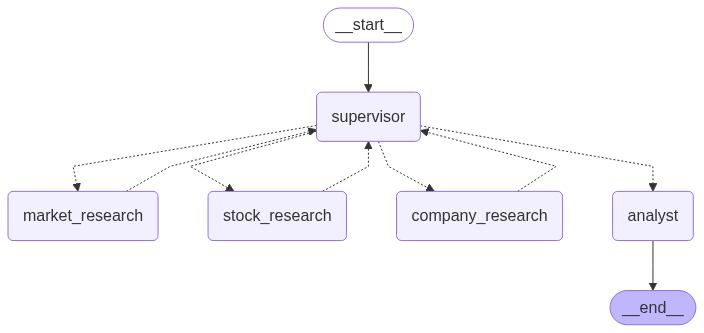

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in Snowflake?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
================================ Human Message =================================
Name: market_research

I cannot provide opinions or investment advice. However, I can provide you with factual information about Snowflake, such as its recent stock performance, financials, and news. Would you like me to gather this information for you?
================================ Human Message =================================
Name: market_research

Please specify what kind of information you would like about Snowflake, such as stock performance, financials, or recent news, and I will provide the relevant data.
================================ Human Message =================================
Name: market_research

Please let me know what kind of information you would like about Snowflake, such as stock performance, financials, or recent news, and I will provide the relevant data.
==========

Failed to get ticker 'SNOW' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNOW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


================================ Human Message =================================
Name: stock_research

It seems there is an issue retrieving the stock price data for Snowflake (ticker: SNOW) at the moment. Please try again later or check a financial platform for the latest stock information.


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SNOW?modules=secFilings&corsDomain=finance.yahoo.com&formatted=false&symbol=SNOW&crumb=Edge%3A+Too+Many+Requests


================================ Human Message =================================
Name: company_research

I attempted to retrieve financial information and SEC filings for Snowflake (ticker: SNOW), but it seems there is no available data at the moment. For the most up-to-date information on Snowflake's financials, I recommend checking financial news websites, stock market platforms, or the SEC's official website for filings.


Failed to get ticker 'SNOW' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNOW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


================================ Human Message =================================
Name: stock_research

It seems there is an issue retrieving the stock price data for Snowflake (ticker: SNOW) at the moment. Please try again later or check a financial platform for the latest stock information.


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SNOW?modules=secFilings&corsDomain=finance.yahoo.com&formatted=false&symbol=SNOW&crumb=Edge%3A+Too+Many+Requests


================================ Human Message =================================
Name: company_research

I attempted to retrieve financial information and SEC filings for Snowflake (ticker: SNOW), but it seems there is no available data at the moment. For the most up-to-date information on Snowflake's financials, I recommend checking financial news websites, stock market platforms, or the SEC's official website for filings.
================================ Human Message =================================
Name: market_research

Here is some factual information about Snowflake Inc. (SNOW):

### Recent Stock Performance (September 2023)
- On September 1, 2023, Snowflake's stock opened at $158.10 and closed at $157.08, with a high of $160.02 and a low of $156.75.
- The trading volume on September 1 was 3,685,404.
- By September 29, 2023, the stock closed at $152.77, with a monthly high of $172.35 on September 11 and a monthly low of $147.05 on September 28.

### Financials (as of Fiscal Yea